<a href="https://colab.research.google.com/github/dorin133/Signal-Processing-236201-all-HW/blob/master/HW1-236201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import libraries 
import matplotlib.pyplot as plt
import imageio
import os
import cv2
import numpy as np
from skimage import io, color
from sklearn.cluster import KMeans
from sklearn.utils import shuffle

In [ ]:
#Load the image
image_orig = io.imread("gray_image.png")
gray_image_orig = color.rgb2gray(image_orig)
gray_image = np.array(gray_image_orig, dtype=np.uint)
h, w= gray_image.shape
gray_image_array = np.reshape(gray_image, (w*h))


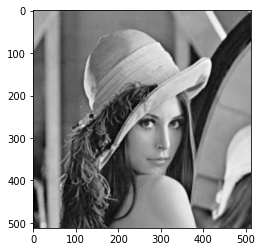

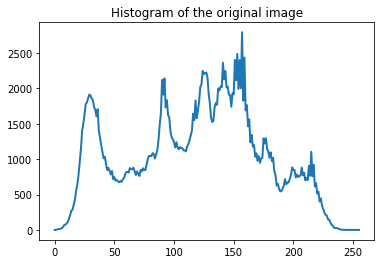

In [ ]:
#plotting the histogram of the gray image

plt.imshow(gray_image, cmap='gray', vmin=gray_image.min(), vmax=gray_image.max())
plt.show()

plt.figure(2)
plt.clf()
plt.title("Histogram of the original image")
hist = np.histogram(gray_image_orig, bins= range(0,257)) 
_ = plt.plot(hist[1][:-1], hist[0], lw=2)

In [ ]:
#function which applies uniform quantization on the image
def uniform_quantization(gray_image_array, b) :
  #according to the formula given in the lecture
  delta = (gray_image_array.max() - gray_image_array.min())/(2**b)
  quantized_array = gray_image_array.min() + (np.floor((gray_image_array - gray_image_array.min())/delta)+0.5)*delta
  return quantized_array

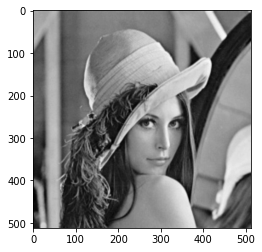

In [ ]:
to_print_quantized = uniform_quantization(gray_image, 7)
plt.imshow(to_print_quantized, cmap='gray', vmin=to_print_quantized.min(), vmax=to_print_quantized.max())
plt.show()

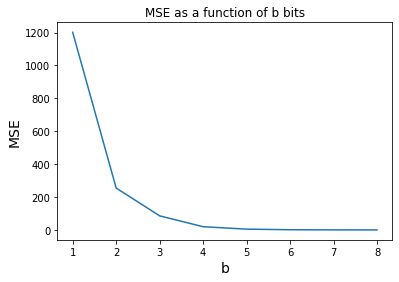

In [ ]:
#calculte the MSE function 
mse_array = np.zeros(8, dtype=np.float64)
for i in range(0,8) :
  #calculating according to the formula of the MSE
  mse_array[i] = np.mean((gray_image_array - uniform_quantization(gray_image_array, i+1))**2)
plt.plot(range(1,9), mse_array)
plt.title("MSE as a function of b bits")
plt.xlabel("b", fontsize = 14)
_ = plt.ylabel("MSE", fontsize = 14)

# New Section

In [ ]:
#for question 2.b. - creating the plot for the decision and represenation levels
def get_decision_and_representation_levels(gray_image_array, b) :
  delta = (gray_image_array.max() - gray_image_array.min())/(2**b)
  decision_levels = np.zeros(2**b+1, dtype=np.float64)
  representation_levels = np.zeros(2**b, dtype=np.uint)
  for i in range(0, 2**b+1) :
    #according to the formula given in the tutorial
    decision_levels[i] = gray_image_array.min() + delta*i
  for i in range(0, 2**b) :
    #according to the formula given in the tutorial
    representation_levels[i] = gray_image_array.min() + (i+0.5)*delta
  return decision_levels, representation_levels

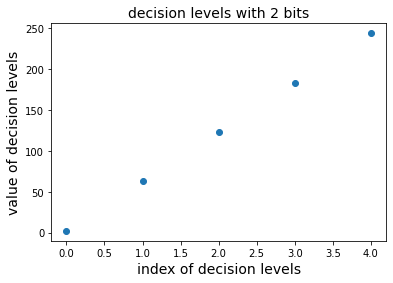

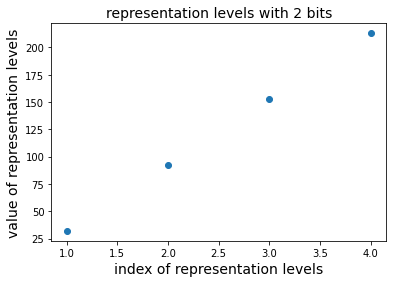

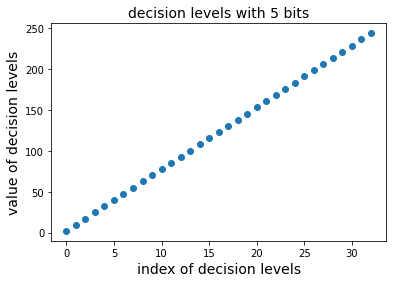

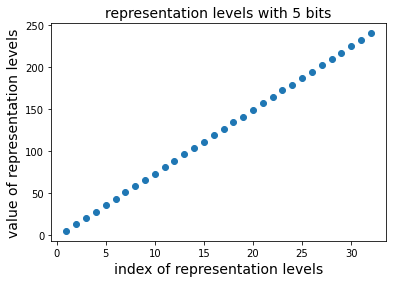

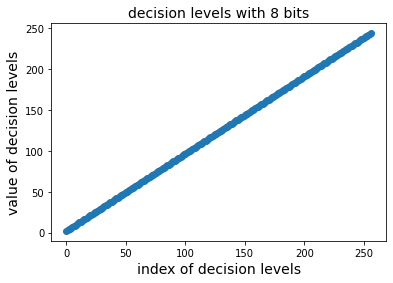

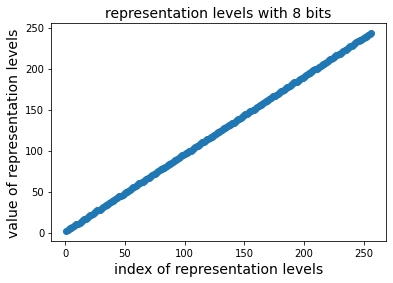

In [ ]:
for i in range(2,9,3) :
  decision_levels , representation_levels = get_decision_and_representation_levels(gray_image_array, i)
  
  #plot the decision levels
  plt.plot(range(0,2**i+1), decision_levels, "o")
  plt.title("decision levels with " +str(i)+ " bits" , fontsize = 14)
  plt.xlabel("index of decision levels", fontsize = 14)
  plt.ylabel("value of decision levels", fontsize = 14)
  plt.show()

  #plot the representation levels
  plt.plot(range(1,2**i+1), representation_levels, "o")
  plt.title("representation levels with " +str(i)+ " bits", fontsize = 14)
  plt.xlabel("index of representation levels", fontsize = 14)
  plt.ylabel("value of representation levels", fontsize = 14)
  _ = plt.show()

In [ ]:
def maxloyd(hist, decision_levels, epsilon):
  decision_levels_new=decision_levels
  num_samples=np.sum(hist)
  representation_levels=calculate_representation(hist,decision_levels_new)
  mse_old=calculate_mse(hist, representation_levels, num_samples)
  #run until stop condition
  while True:
    decision_levels_new=calculate_decision(representation_levels, decision_levels_new)
    representation_levels=calculate_representation(hist,decision_levels_new)
    mse=calculate_mse(hist, representation_levels, num_samples)
    if(np.abs(mse-mse_old)<epsilon):
      return decision_levels_new, representation_levels, mse
    mse_old=mse
  

In [ ]:
def calculate_representation(hist, decision_levels):
  #according to formula from lecture
  xpx=np.array([x*hist[x] for x in range(0,hist.size)])
  representation_levels = np.zeros(decision_levels.size-1, dtype=np.uint)
  for i in range(0,representation_levels.size):
    temp1=np.sum(hist[np.uint(np.ceil(decision_levels[i])):np.uint(np.ceil(decision_levels[i+1]))])
    temp2=np.sum(xpx[np.uint(np.ceil(decision_levels[i])):np.uint(np.ceil(decision_levels[i+1]))])
    # in an empty sense, this decision level is uniformly ditributed, 
    # which means that the average (representation level) is equal to the meadian 
    if(temp1==0 or temp2==0):
      representation_levels[i]=(np.uint(decision_levels[i]+decision_levels[i+1]))/2
    else:
      representation_levels[i]=temp2/temp1
  return representation_levels

In [ ]:
def calculate_mse(hist, representation_levels, num_samples):
  mse=0
  for i in range(0,hist.size):
    #we find the representation by the closest representation level to each value,
    #instead of searching for the lower and upper decision bounds because 
    #they were made in such a way that the representation of each value is the representation level closest to it
    representation_squared=((representation_levels-i)**2).min()
    #representation=representation_levels[representation_index]
    mse+=hist[i]*representation_squared
  mse/=num_samples
  return mse

In [ ]:
def calculate_decision(representation_levels, decision_levels):
  #according to formula from lecture
  for i in range(1,decision_levels.size-1):
    decision_levels[i] = (representation_levels[i-1]+representation_levels[i])/2
  return decision_levels

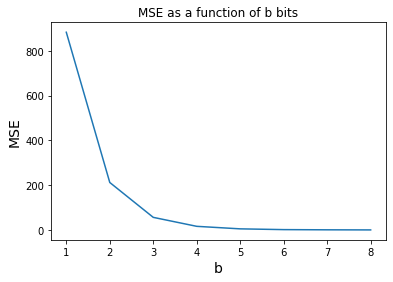

In [ ]:
# Q3.a the plot of the MSE using maxlloyd
mse_array_ml = np.zeros(8, dtype=np.float64)
for i in range(0,8) :
  decision, representation = get_decision_and_representation_levels(gray_image_array,i+1)
  decision, representation, mse = maxloyd(hist[0], decision, 0.1)
  mse_array_ml[i] = mse
plt.plot(range(1,9), mse_array_ml)
plt.title("MSE as a function of b bits")
plt.xlabel("b", fontsize = 14)
_ = plt.ylabel("MSE", fontsize = 14)

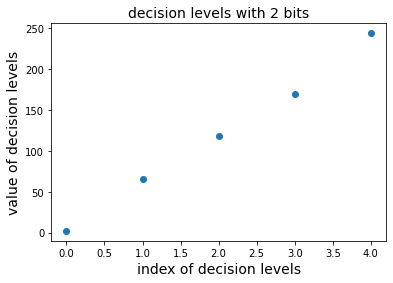

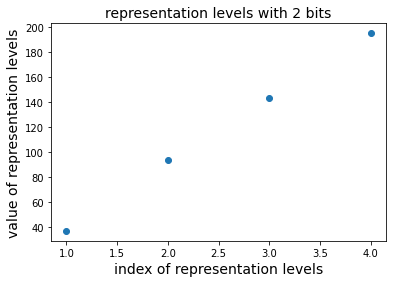

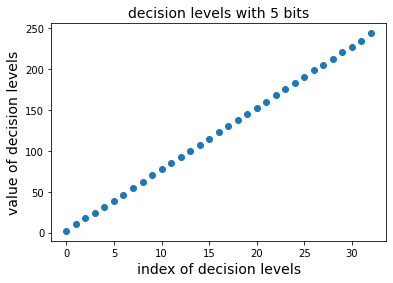

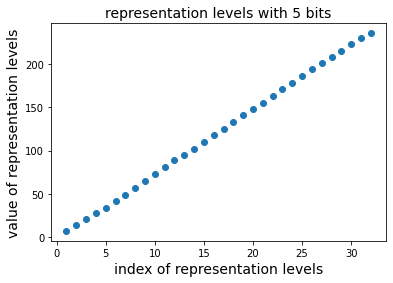

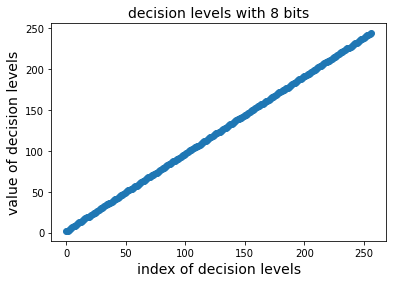

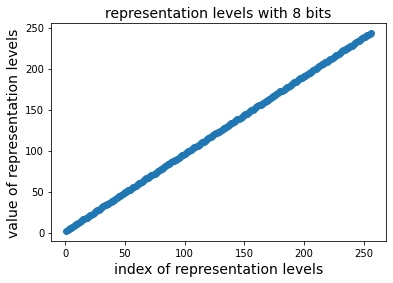

In [ ]:
#Q3.b plotting the decision and representation levels from max-lloyd
for i in range(2,9,3) :
  decision, representation = get_decision_and_representation_levels(gray_image_array,i)
  decision, representation, mse = maxloyd(hist[0], decision, 0.1) 

  #plot the decision levels
  plt.plot(range(0,2**i+1), decision, "o")
  plt.title("decision levels with " +str(i)+ " bits" , fontsize = 14)
  plt.xlabel("index of decision levels", fontsize = 14)
  plt.ylabel("value of decision levels", fontsize = 14)
  plt.show()

  #plot the representation levels
  plt.plot(range(1,2**i+1), representation, "o")
  plt.title("representation levels with " +str(i)+ " bits", fontsize = 14)
  plt.xlabel("index of representation levels", fontsize = 14)
  plt.ylabel("value of representation levels", fontsize = 14)
  _ = plt.show()

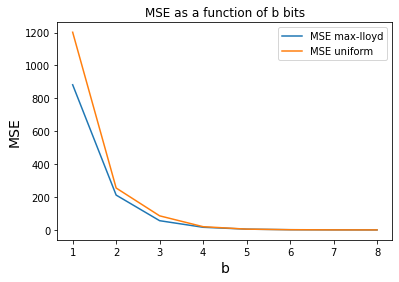

In [ ]:
#Q3.c compare the MSE of max-lloyd and MSE from uniform quantization
first_plt, = plt.plot(range(1,9), mse_array_ml, label = 'MSE max-lloyd')
second_plt, = plt.plot(range(1,9), mse_array, label = 'MSE uniform')
plt.title("MSE as a function of b bits")
plt.xlabel("b", fontsize = 14)
_ = plt.ylabel("MSE", fontsize = 14)
plt.legend(handles = [first_plt, second_plt])
plt.show()

## Part 2 : subsampling and reconstruction

In [ ]:
def grid_image_mse(gray_image, d):
  grid_gray_image = np.zeros((d,d))
  jump = gray_image.shape[0]//d
  for i in range(0,d):
    for j in range(0,d):
      grid_gray_image[i][j]= np.mean(gray_image[i*jump:(i+1)*jump,j*jump:(j+1)*jump])+0.5
  return grid_gray_image

def grid_image_mad(gray_image, d):
  grid_gray_image = np.zeros((d,d))
  jump = gray_image.shape[0]//d
  for i in range(0,d):
    for j in range(0,d):
      grid_gray_image[i][j]= np.median(gray_image[i*jump:(i+1)*jump,j*jump:(j+1)*jump])+0.5
  return grid_gray_image

In [ ]:
def form_reconstruction(grid_gray_image, shape_image_orig):
  reconstructed_image = np.zeros((shape_image_orig,shape_image_orig))
  jump = shape_image_orig//grid_gray_image.shape[0]
  for i in range(0,grid_gray_image.shape[0]):
    for j in range(0,grid_gray_image.shape[0]):
      reconstructed_image[i*jump:(i+1)*jump,j*jump:(j+1)*jump]= grid_gray_image[i][j]
  return reconstructed_image

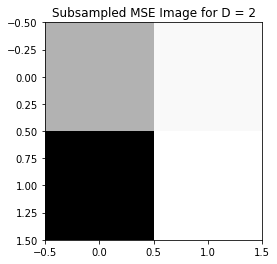

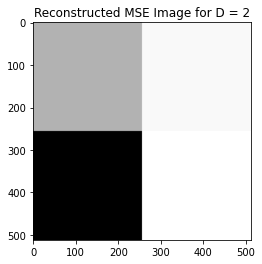

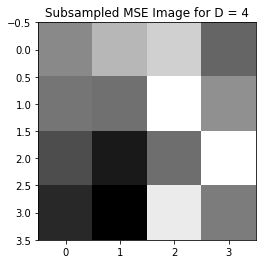

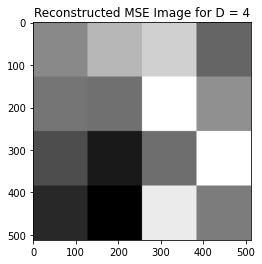

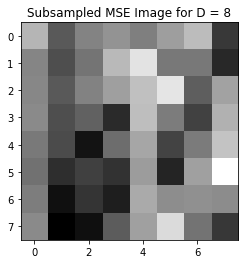

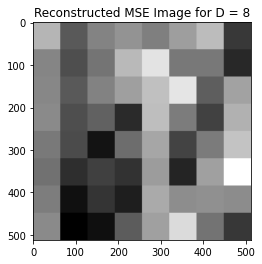

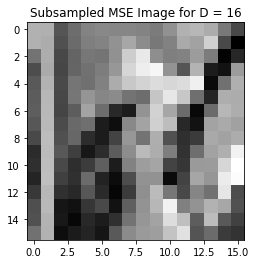

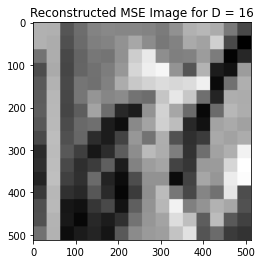

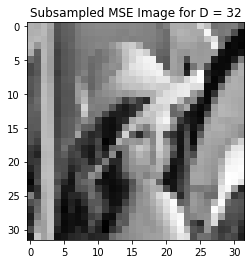

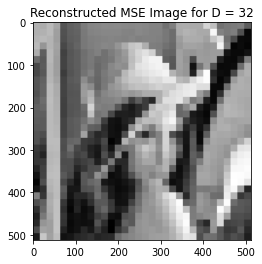

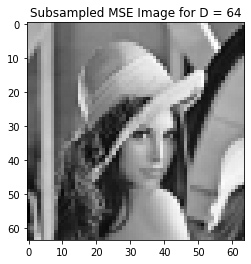

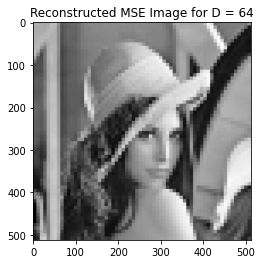

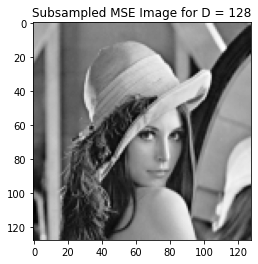

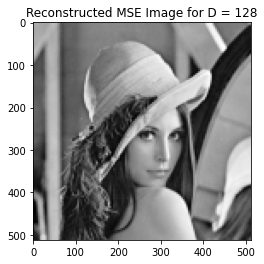

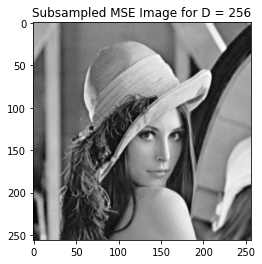

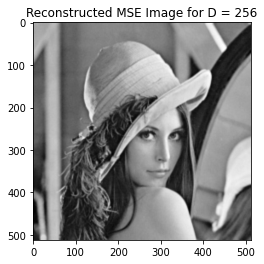

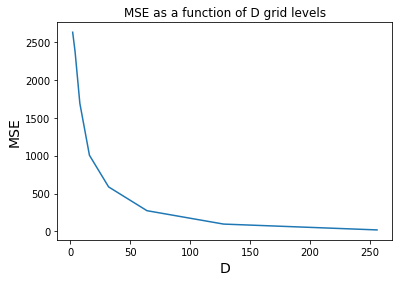

In [ ]:
#calculte the MSE function 
mse_array = np.zeros(8, dtype=np.float64)
mad_array = np.zeros(8, dtype=np.float64)
#print(gray_image[256:511,256:511].shape)
for i in range(0,8):
  #calculating according to the formula of the MSE
  small_image = grid_image_mse(gray_image, 2**(i+1))
  reconstructed_image = form_reconstruction(small_image, gray_image.shape[0])
  mse_array[i] = np.mean((gray_image - reconstructed_image)**2)
  plt.title("Subsampled MSE Image for D = "+str(2**(i+1)))
  plt.imshow(small_image, cmap='gray', vmin=small_image.min(), vmax=small_image.max())
  plt.show()

  plt.title("Reconstructed MSE Image for D = "+str(2**(i+1)))
  plt.imshow(reconstructed_image, cmap='gray', vmin=reconstructed_image.min(), vmax=reconstructed_image.max())
  _ = plt.show()

plt.plot(np.logspace(1,8,8,base=2), mse_array)
plt.title("MSE as a function of D grid levels")
plt.xlabel("D", fontsize = 14)
_ = plt.ylabel("MSE", fontsize = 14)

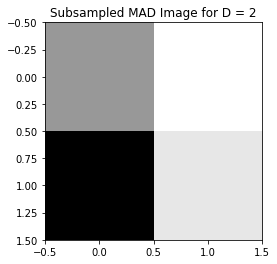

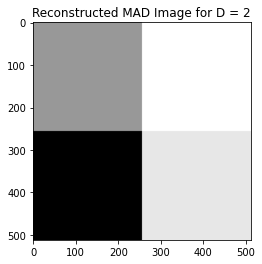

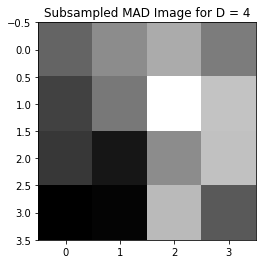

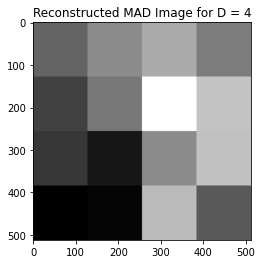

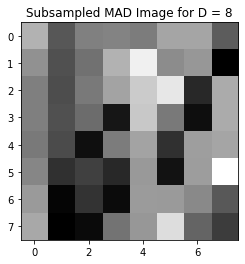

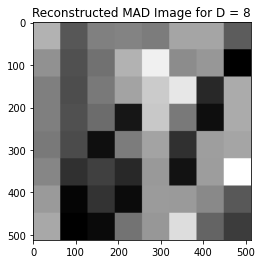

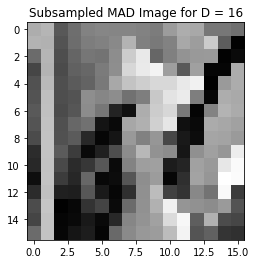

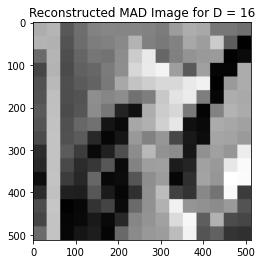

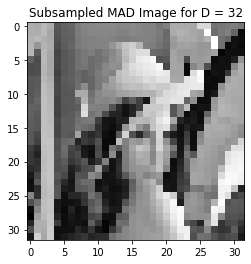

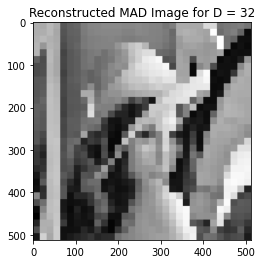

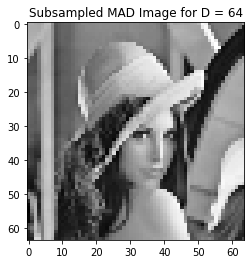

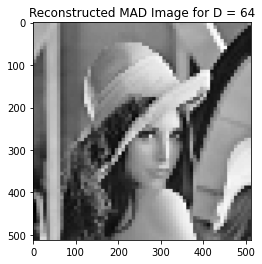

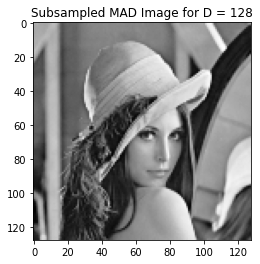

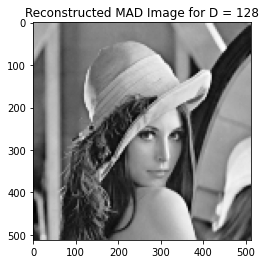

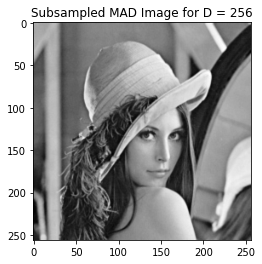

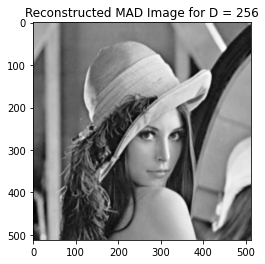

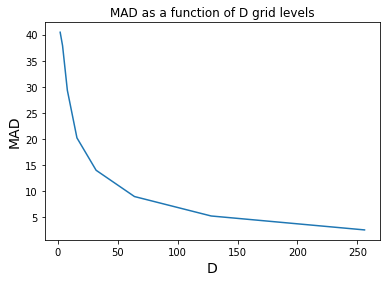

In [ ]:
#TODO: print Subsampled MAD image (small + reconstructed) + Q3
#calculte the MAD function 
for i in range(0,8):
  #calculating according to the formula of the MSE
  small_image_mad = grid_image_mad(gray_image, 2**(i+1))
  reconstructed_image_mad = form_reconstruction(small_image_mad, gray_image.shape[0])
  mad_array[i] = np.mean(np.abs(gray_image - reconstructed_image_mad))
  plt.title("Subsampled MAD Image for D = "+str(2**(i+1)))
  plt.imshow(small_image_mad, cmap='gray', vmin=small_image_mad.min(), vmax=small_image_mad.max())
  plt.show()

  plt.title("Reconstructed MAD Image for D = "+str(2**(i+1)))
  plt.imshow(reconstructed_image_mad, cmap='gray', vmin=reconstructed_image_mad.min(), vmax=reconstructed_image_mad.max())
  _ = plt.show()

plt.plot(np.logspace(1,8,8,base=2), mad_array)
plt.title("MAD as a function of D grid levels")
plt.xlabel("D", fontsize = 14)
_ = plt.ylabel("MAD", fontsize = 14)

## Part 3:

In [ ]:
#Q3.2 L^p algorithm implementation
def lp_solver(gray_image, intervals, p, epsilon, delta):
  sampled_image = np.zeros((intervals,intervals), dtype=np.float64)
  jump = gray_image.shape[0]//intervals
  #first calculate the error with an all zeros approximation as reference
  # no need to apply np.abs since the values of gray_image are positive
  lp_error_old =  np.mean((gray_image)**p)
  #calculate the next weight and sampled image
  while True :
    lp_error_sum = 0
    for i in range(0 , intervals) : 
      for j in range(0 , intervals) : 
        #fisrt, calculate the weight
        temp1=np.array(1/epsilon, dtype=np.float64)
        temp2=(np.abs(gray_image[i*jump:(i+1)*jump,j*jump:(j+1)*jump]-sampled_image[i][j]))**(p-2)
        weight = np.minimum(temp1, temp2)
        weighted_interval = gray_image[i*jump:(i+1)*jump,j*jump:(j+1)*jump]*weight
        if (np.sum(weight) == 0) :
          sampled_image[i][j]=0
        else:
          sampled_image[i][j] = np.sum(weighted_interval)/(np.sum(weight))
        lp_error_sum += np.sum((np.abs(gray_image[i*jump:(i+1)*jump,j*jump:(j+1)*jump]-sampled_image[i][j]))**p)
    lp_error = lp_error_sum/gray_image.size
    if(np.abs(lp_error - lp_error_old) < delta):
      return sampled_image, lp_error
    lp_error_old = lp_error

In [ ]:
#Q3.3 L1 solver
def l1_solver(gray_image, intervals):
  sampled_image = np.zeros((intervals,intervals), dtype=np.float64)
  jump = gray_image.shape[0]//intervals
  l1_error_sum=0
  for i in range(0 , intervals) : 
    for j in range(0 , intervals) : 
      sampled_image[i][j]=np.median(gray_image[i*jump:(i+1)*jump,j*jump:(j+1)*jump])
      l1_error_sum+=np.sum(np.abs(gray_image[i*jump:(i+1)*jump,j*jump:(j+1)*jump]-sampled_image[i][j]))
  l1_error=l1_error_sum/gray_image.size
  return sampled_image, l1_error

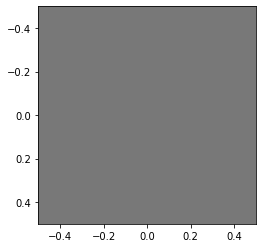

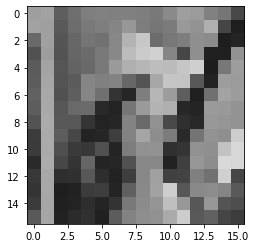

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in reciprocal
  


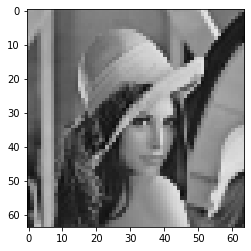

In [ ]:
gray_image_float=gray_image.astype(np.float64)/255
error_array=np.zeros((5,6))
l1_error_array=np.zeros(5)
i=0
j=0
for N in np.logspace(0,8, num=5, base=2):
  j=0
  for epsilon in np.logspace(-1,-6,num=6,base=10):
    sampled_approximation, l1_approximation=lp_solver(gray_image_float,int(N),1,epsilon,0.001)
    error_array[i][j]=l1_approximation
    if ((i==0 and j==0) or (i==2 and j==3) or (i==3 and j==5)):
      #printing choice sampled images
      plt.imshow(sampled_approximation, cmap='gray', vmin=0, vmax=1)
      plt.show()
    j+=1
  sampled_image, l1_error=l1_solver(gray_image_float,int(N))
  l1_error_array[i]=l1_error
  i+=1

In [ ]:
print(error_array)
print(l1_error_array)

[[0.17850248 0.17912111 0.17956881 0.18061626 0.18061626 0.18061626]
 [0.14967367 0.14932498 0.15009589 0.1503187  0.15058083 0.15058083]
 [0.08071881 0.08035571 0.08073348 0.08122823 0.08128891 0.08129022]
 [0.03553914 0.03558631 0.03645956 0.03649828 0.03649961 0.03649961]
 [0.00957382 0.00953721 0.00949358 0.00949306 0.00949305 0.00949305]]
[0.17791325 0.14848942 0.07905242 0.03475852 0.00946824]


error for l4 approximation is 0.0041725617724719605


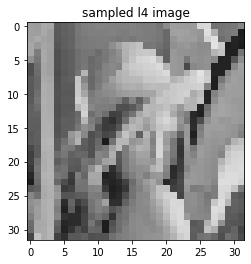

error for l3/2 approximation is 0.020843461138538848


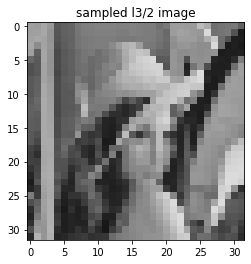

In [ ]:
sampled_l4_approximation, l4_error=lp_solver(gray_image_float,2**5,4,0.00001,0.001)
sampled_l32_approximation, l32_error=lp_solver(gray_image_float,2**5,1.5,0.00001,0.001)
print("error for l4 approximation is "+str(l4_error))
plt.imshow(sampled_l4_approximation, cmap='gray', vmin=0, vmax=1)
plt.title("sampled l4 image")
plt.show()

print("error for l3/2 approximation is "+str(l32_error))
plt.imshow(sampled_l32_approximation, cmap='gray', vmin=0, vmax=1)
plt.title("sampled l3/2 image")
plt.show()

In [ ]:
l4_err_arr = np.zeros(8)
l32_err_arr = np.zeros(8)

for i in range (0,8):
  sampled_l4_approximation, l4_error=lp_solver(gray_image_float,int(2**i),4,0.00001,0.005)
  sampled_l32_approximation, l32_error=lp_solver(gray_image_float,int(2**i),1.5,0.00001,0.005)
  l4_err_arr[i]=l4_error
  l32_err_arr[i]=l32_error

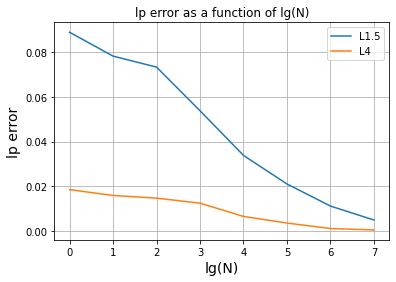

In [ ]:
#Q3.c compare the MSE of max-lloyd and MSE from uniform quantization
first_plt, = plt.plot(range(0,8), l32_err_arr, label = 'L1.5')
second_plt, = plt.plot(range(0,8), l4_err_arr, label = 'L4')
plt.title("lp error as a function of lg(N)")
plt.grid()
plt.xlabel("lg(N)", fontsize = 14)
_ = plt.ylabel("lp error", fontsize = 14)
plt.legend(handles = [first_plt, second_plt])
plt.show()
